# March Madness Data Crunch

Objective: Utilize historical data, player performance, and additional features to build a model that accurately predicts 2023 March Madness NCAA Men’s Basketball tournament result.

## Step1: Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import warnings 
from math import sin, cos, sqrt, atan2, radians
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score, f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf


%pylab inline
%config InlineBackend.figure_formats = ['retina']

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

sns.set()
pd.set_option('display.max_columns', None)

# Load the data
# np.random.seed(0)
# filename = 'NCAA_Tourney_2002_2022.csv'
filename = 'NCAA_Tourney_2002_2022.csv'
filepath = '/Users/masayasugimotohomefolder/Desktop/MarchMadness/'
df = pd.read_csv(filepath + filename).reset_index(drop = True)

# Statistics
df.describe()

# Check percentage of missing values for each column
check = df.isna().sum()/df.shape[0]

# Drop columns with bigger than 10% non - missing values
cols_to_drop = check[check > 0.1].index
df = df.drop(columns = cols_to_drop)

#%% Randomize the team1 winning result and then swap with team2 data

# Randomize the value
import random

df_swapped = df.copy()
random.seed(10)

# Loop over each row in the DataFrame (Takes long time)
for idx, row in df_swapped.iterrows():
    if random.choice([True, False]):
        # Swap team1_id and team2_id
        team1_id = row['team1_id']
        team2_id = row['team2_id']
        df_swapped.loc[idx, 'team1_id'] = team2_id
        df_swapped.loc[idx, 'team2_id'] = team1_id
        # Update all variables related to each team
        for col in df_swapped.columns:
            if col.startswith("team1_"):
                team1_val = row[col]
                team2_col = col.replace("team1_", "team2_")
                df_swapped.loc[idx, col] = row[team2_col]
                df_swapped.loc[idx, team2_col] = team1_val
            elif col.startswith("team2_"):
                team2_val = row[col]
                team1_col = col.replace("team2_", "team1_")
                df_swapped.loc[idx, col] = row[team1_col]
                df_swapped.loc[idx, team1_col] = team2_val

# Delete the 'game_id' column from the DataFrame
df_swapped.drop('game_id', axis=1, inplace=True)

# Create a new 'game_id' column with a string consisting of the 'season', 'team1_id', and 'team2_id' values
df_swapped['game_id'] = df_swapped['season'].astype(str) + '-' + df_swapped['team1_id'].astype(str) + '-' + df_swapped['team2_id'].astype(str)

#%% Calculate Distance by lat and lon
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

df_swapped['team1_dist'] = df_swapped.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis = 1)
df_swapped['team2_dist'] = df_swapped.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis = 1)
df_swapped['diff_dist'] = df_swapped['team1_dist'] - df_swapped['team2_dist']

#%% Pythag College Basketball

# E(W%) = points scored^13.91 / (points scored^13.91 + points allowed^13.91
df_swapped['exp_win1'] = df_swapped['team1_adjoe'] ** 13.91 / ((df_swapped['team1_adjde'] ** 13.91) + (df_swapped['team1_adjoe'] ** 13.91))
df_swapped['exp_win2'] = df_swapped['team2_adjoe'] ** 13.91 / ((df_swapped['team2_adjde'] ** 13.91) + (df_swapped['team2_adjoe'] ** 13.91))

#%% Log Odds (Log5)

# P(W) = (A - A * B) / (A + B - 2 * A * B)
df_swapped['team1_log5'] = (df_swapped['exp_win1'] - (df_swapped['exp_win1'] * df_swapped['exp_win2']))/(df_swapped['exp_win1'] + df_swapped['exp_win2'] - (2 * df_swapped['exp_win1'] * df_swapped['exp_win2']))
(df_swapped[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].sort_values("team1_log5", ascending = False).head())

#%% Add columns

# Add new column for team1_closer if dist1 is larger than dist2 (Far = 0, Close = 1)
df_swapped['team1_closer'] = (df_swapped['team1_dist'] < df_swapped['team2_dist']).astype(int)

# Add new column for team1_closer if dist1 is larger than dist2 (Far = 0, Close = 1)
# df_swapped['team1_highexp'] = (df_swapped['exp_win1'] > df_swapped['exp_win2']).astype(int)

# Drop the distance variables for both team1 and team2
df_swapped = df_swapped.drop(['team1_dist', 'team2_dist'], axis = 1)

# Seed Diff
df_swapped['seed_diff'] = df_swapped['team1_seed'] - df_swapped['team2_seed']

# Add new column for team1_won (Win = 1, Lose  = 0)
df_swapped['team1_won'] = (df_swapped['team1_score'] > df_swapped['team2_score']).astype(int)

#%% Clean Data

# Create a new DataFrame with the numerical columns only
numerical_columns = df_swapped.select_dtypes(include = 'number').columns.tolist()
df_numerical = df_swapped[numerical_columns].copy()



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/basics310/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt', 'cos', 'radians', 'sin']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Step2:  Data Merge

### Funding Dataset

In [2]:
#Load csv file
funding_df = pd.read_csv('/Users/masayasugimotohomefolder/Desktop/MarchMadness/combined_funding_stat.csv')

#Add one year to each year
funding_df['year'] = funding_df['year'] + 1

# Rename the 'TeamID' and 'year' columns in dataset2 to match dataset1's column names
team1_funding_df = funding_df.rename(columns={'TeamID': 'team1_id', 'year': 'season'})

# Add 'team1_' prefix to the specified columns in dataset2
columns_to_prefix = ['opexpperpart_men', 'opexpperteam_men', 'rev_men','exp_men']
team1_funding_df.columns = ['team1_' + col if col in columns_to_prefix else col for col in team1_funding_df.columns]

# Merge the datasets based on 'season' and 'team1_id'
merged_dataset = df_numerical.merge(team1_funding_df, on=['season', 'team1_id'])

# Rename the 'TeamID' and 'year' columns in dataset2 to match dataset1's column names
team2_funding_df = funding_df.rename(columns={'TeamID': 'team2_id', 'year': 'season'})

# Add 'team1_' prefix to the specified columns in dataset2
columns_to_prefix = ['opexpperpart_men','opexpperteam_men', 'rev_men','exp_men']
team2_funding_df.columns = ['team2_' + col if col in columns_to_prefix else col for col in team2_funding_df.columns]

# Merge the datasets based on 'season' and 'team1_id'
merged_dataset = merged_dataset.merge(team2_funding_df, on=['season', 'team2_id'])

### Starplayer Dataset

In [3]:
star_df = pd.read_csv('/Users/masayasugimotohomefolder/Desktop/MarchMadness/HeroRating.csv')

# Rename the 'TeamID' and 'year' columns in dataset2 to match dataset1's column names
team1_star_df = star_df.rename(columns={'TeamID': 'team1_id', 'year': 'season'})

# Add 'team1_' prefix to the specified columns in dataset2
# columns_to_prefix = ['herop_pctof_tpts', 'n_topp', 'n_topp_fr', 'n_topp_so', 'n_topp_jr', 'n_topp_sr']
columns_to_prefix = ['herop_percentot']
team1_star_df.columns = ['team1_' + col if col in columns_to_prefix else col for col in team1_star_df.columns]

# Merge the datasets based on 'season' and 'team1_id'
merged_dataset = merged_dataset.merge(team1_star_df, on=['season', 'team1_id'])

# Rename the 'TeamID' and 'year' columns in dataset2 to match dataset1's column names
team2_star_df = star_df.rename(columns={'TeamID': 'team2_id', 'year': 'season'})

# Add 'team1_' prefix to the specified columns in dataset2
# columns_to_prefix = ['herop_pctof_tpts', 'n_topp', 'n_topp_fr', 'n_topp_so', 'n_topp_jr', 'n_topp_sr']
columns_to_prefix = ['herop_percentot']
team2_star_df.columns = ['team2_' + col if col in columns_to_prefix else col for col in team2_star_df.columns]

# Merge the datasets based on 'season' and 'team1_id'
merged_dataset = merged_dataset.merge(team2_star_df, on=['season', 'team2_id'])

## Step3: Feature Engineering

In [4]:
#Preprocessing the data to calculate difference
merged_dataset = merged_dataset.rename(columns={'exp_win1': 'team1_exp', 'exp_win2': 'team2_exp', 'team1_log5': 'log5'})
features = ["score","seed", "lat", "long", "pt_school_ncaa", "pt_overall_ncaa", "pt_school_s16", "pt_overall_s16", "pt_school_ff", "pt_overall_ff", "pt_career_school_wins", "pt_career_school_losses", "pt_career_overall_wins", "pt_career_overall_losses", "pt_team_season_wins", "pt_team_season_losses", "pt_coach_season_wins", "pt_coach_season_losses", "fg2pct", "fg3pct", "ftpct", "blockpct", "oppfg2pct", "oppfg3pct", "oppftpct", "oppblockpct", "f3grate", "oppf3grate", "arate", "opparate", "stlrate", "oppstlrate", "tempo", "adjtempo", "oe", "adjoe", "de", "adjde", 'opexpperpart_men','opexpperteam_men', 'rev_men','exp_men', 'exp', 'herop_percentot']

merged_dataset = merged_dataset.select_dtypes(include='number')
merged_dataset = merged_dataset.drop(columns=['team1_id', 'team2_id', 'strongseed', 'weakseed', 'season', 'num_ot', 'host_lat', 'host_long'])

# Use list comprehension to create new columns for the difference between team1 and team2
merged_dataset[[f"{feature}_diff" for feature in features]] = merged_dataset[[f"team1_{feature}" for feature in features]].values - merged_dataset[[f"team2_{feature}" for feature in features]].values

# Use list comprehension to drop the original team1 and team2 columns
merged_dataset = merged_dataset[[col for col in merged_dataset.columns if not col.startswith("team1_") and not col.startswith("team2_")]]

# create a boolean mask of NaN values
mask = merged_dataset.isnull()

# identify columns with at least one NaN value
cols_with_nan = mask.any()

# extract column names with NaN values
cols_with_nan_names = cols_with_nan[cols_with_nan == True].index.tolist()

# remove columns with NaN values
merged_dataset = merged_dataset.drop(columns=cols_with_nan_names)
merged_dataset = merged_dataset.drop(columns=['lat_diff', 'long_diff'])


# updated dataframe
merged_dataset

# Target Valiable Creation
merged_dataset['team1_won'] = np.where(merged_dataset['score_diff'] < 0, 0, 1)




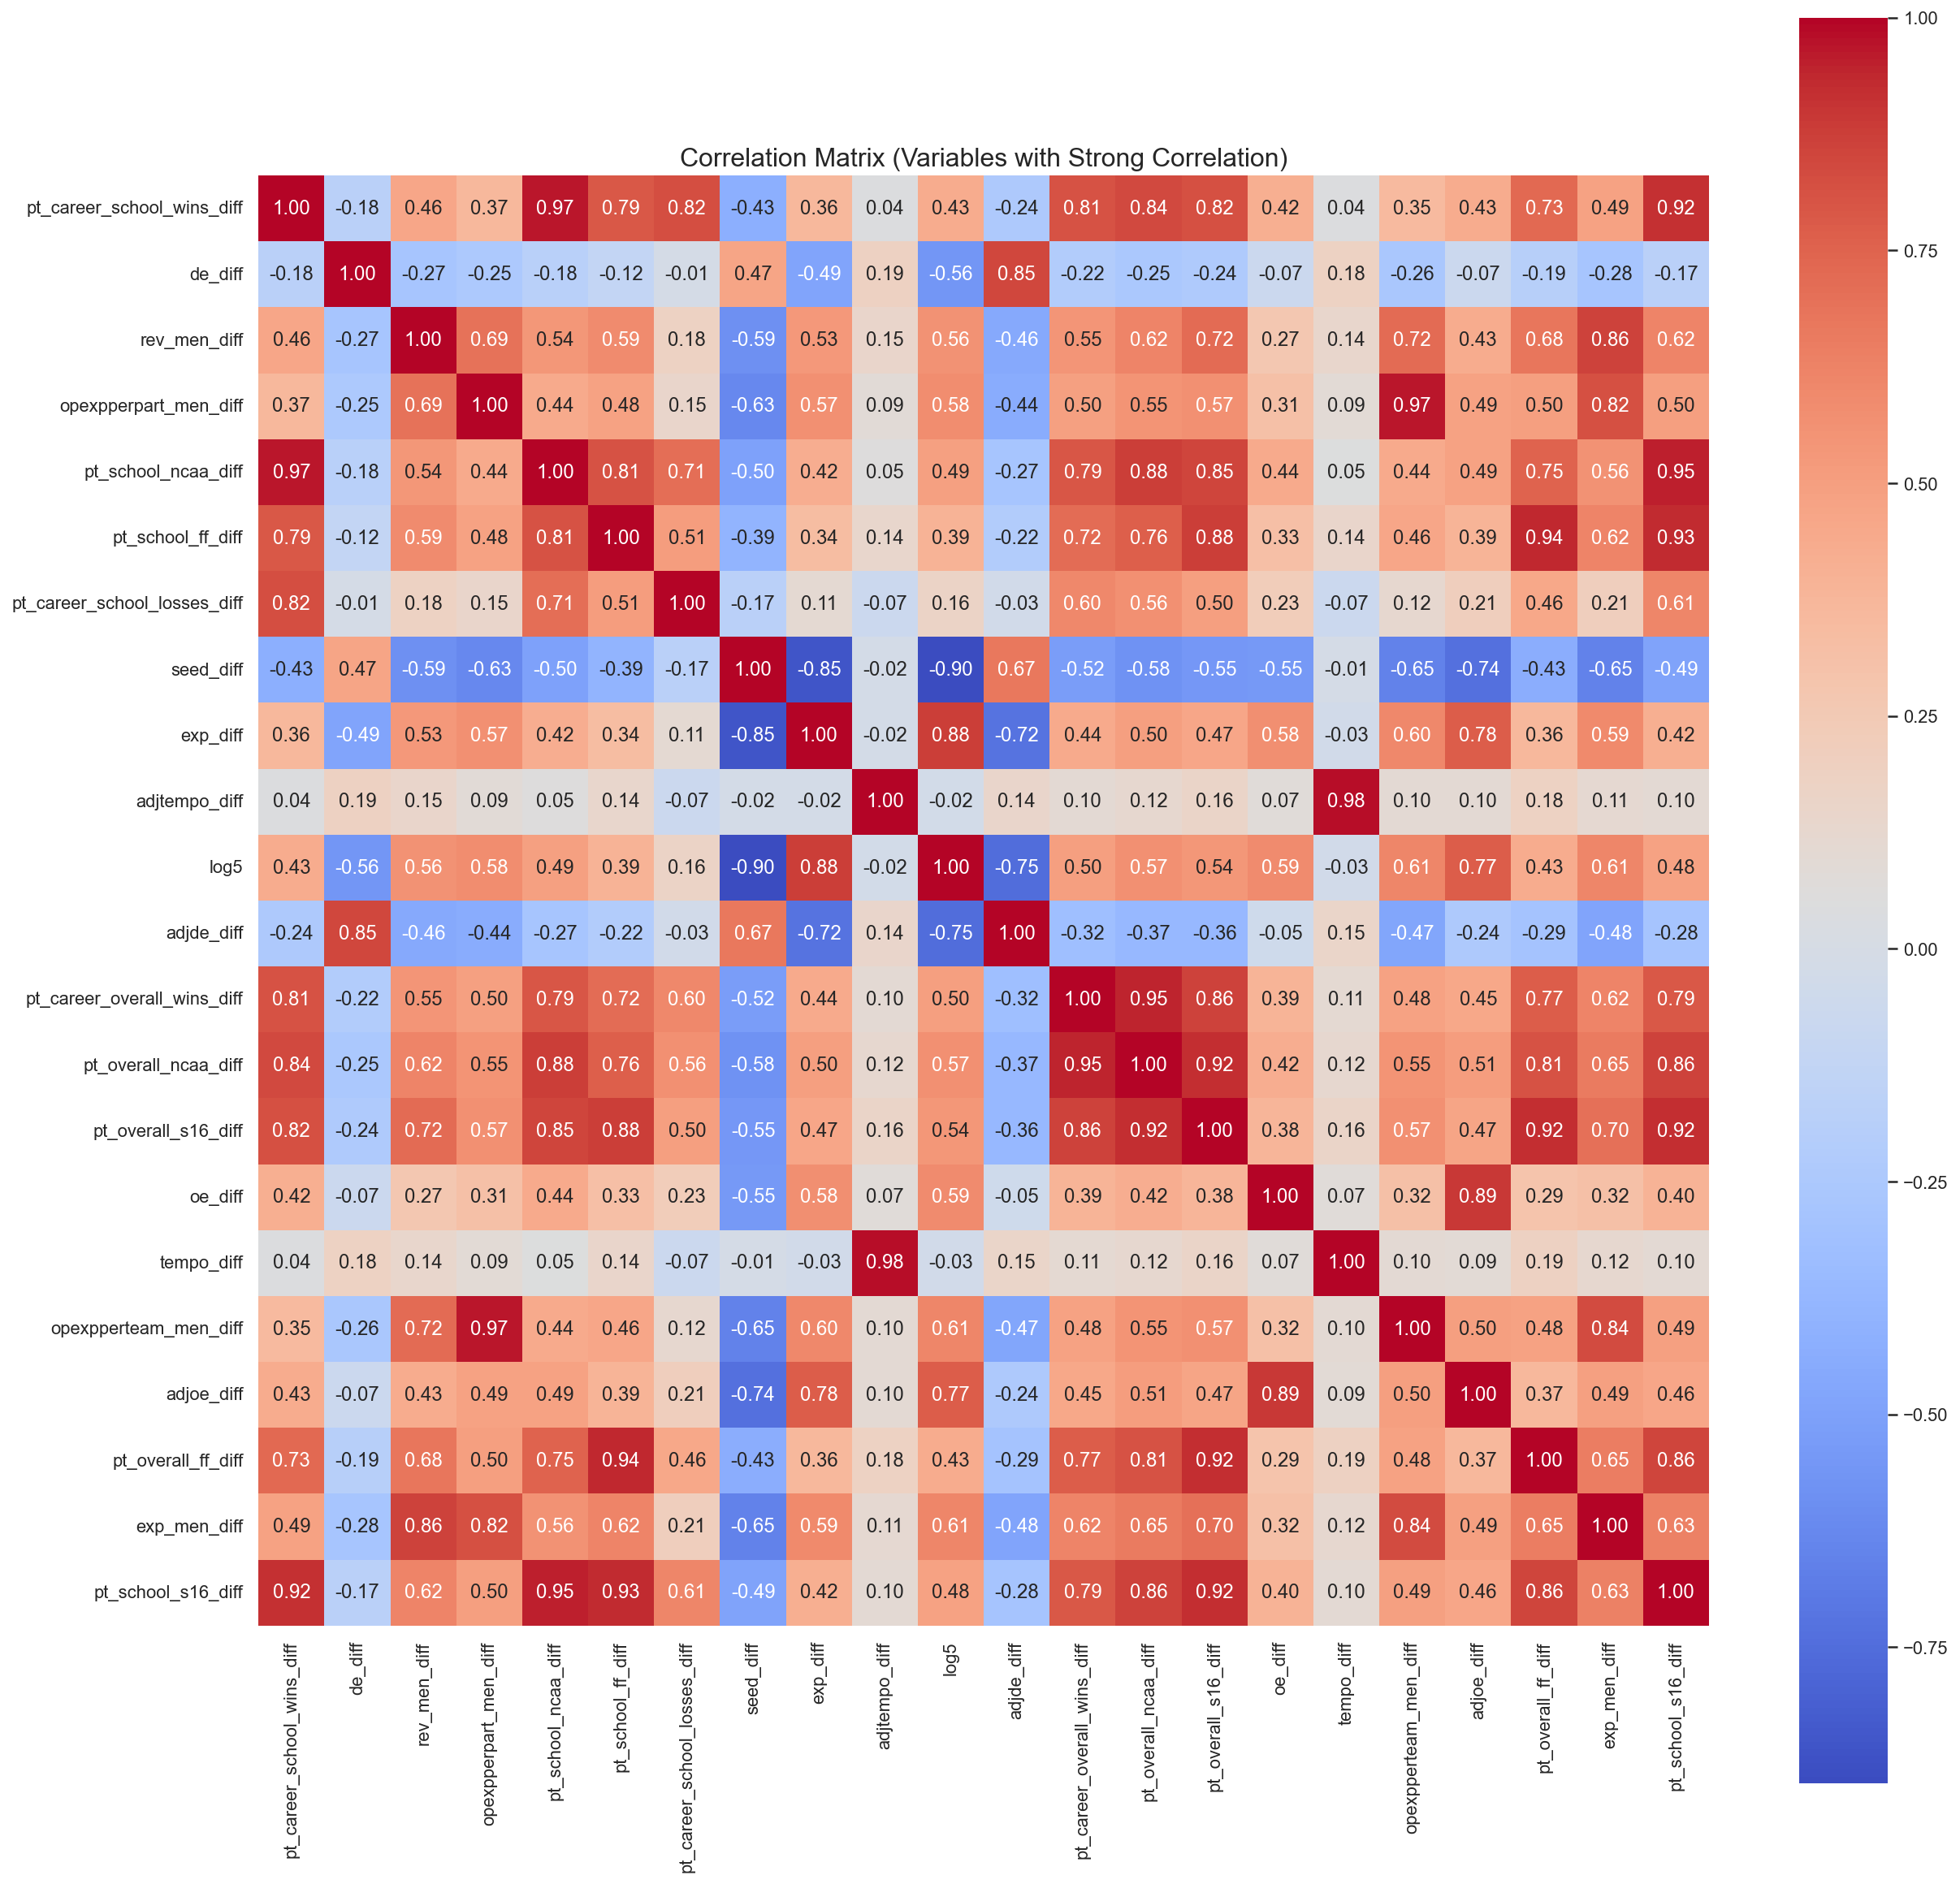

In [5]:
# Calculate the correlation matrix
corr_matrix = merged_dataset.corr()

# Find the indices where the correlation is greater than 0.8
row, col = np.where(np.abs(corr_matrix) > 0.8)

# Extract the unique variable names from the indices
vars_with_strong_corr = set()
for i in range(len(row)):
    if row[i] != col[i]:
        vars_with_strong_corr.add(corr_matrix.columns[row[i]])
        vars_with_strong_corr.add(corr_matrix.columns[col[i]])

# Create a new correlation matrix with only the variables that have strong correlation
strong_corr_matrix = merged_dataset[list(vars_with_strong_corr)].corr()

# Create a heatmap to visualize the strong correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(strong_corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.title('Correlation Matrix (Variables with Strong Correlation)', fontsize=16)
plt.show()

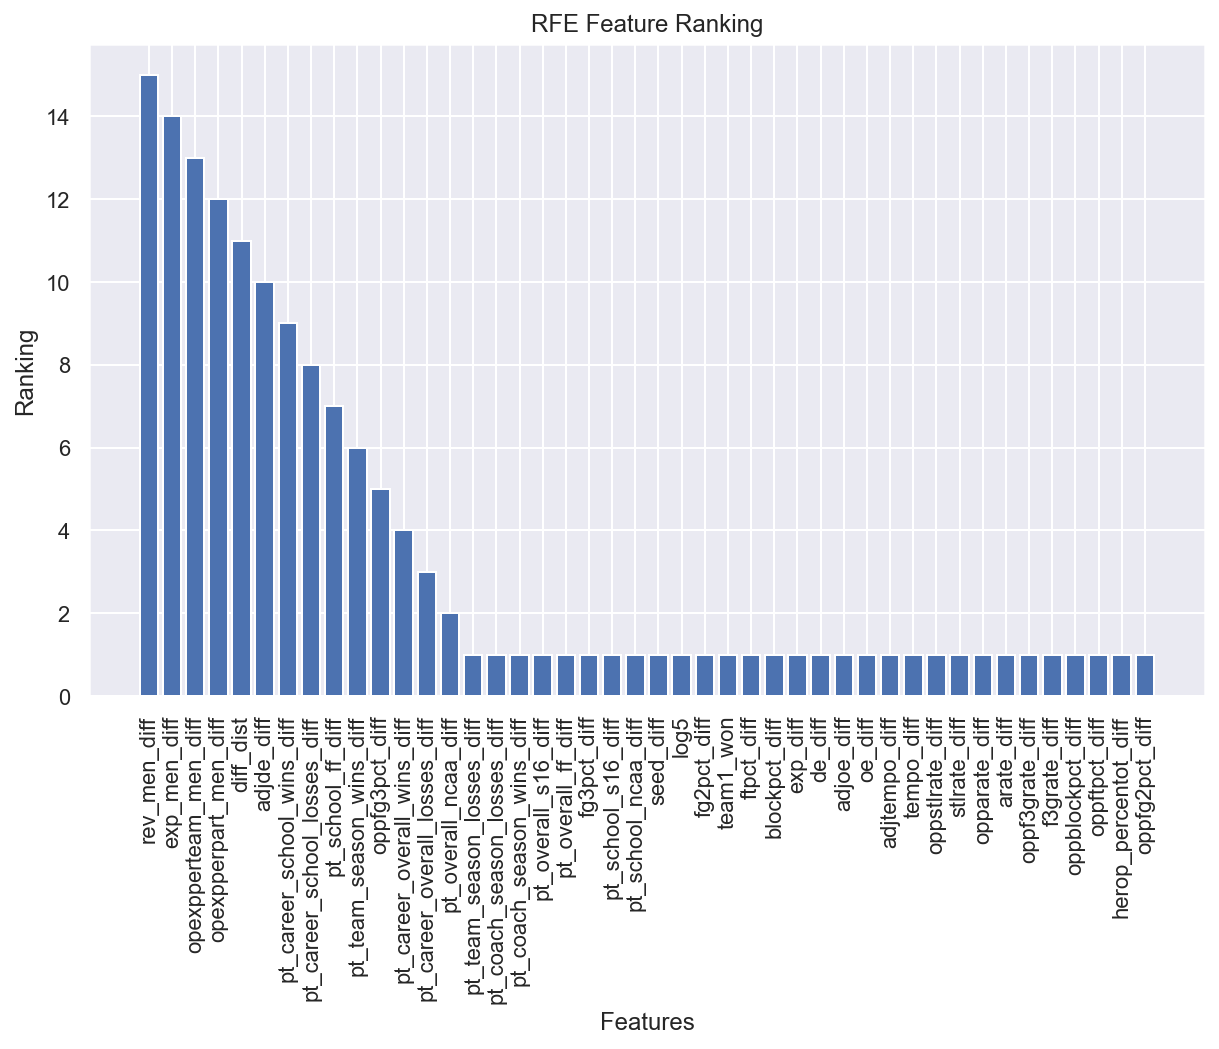

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Define the model for feature selection
model = LinearRegression()

# define feature_cols based on all columns in df except for the target column
feature_cols = [col for col in merged_dataset.columns if col != 'score_diff']

# split the data into train and test sets
train, test = train_test_split(merged_dataset, test_size=0.3, random_state=42)

# create the linear regression model
lr = LinearRegression()

# Split the data into X (features) and y (target variable)
X = merged_dataset.drop('score_diff', axis=1)
y = merged_dataset['score_diff']

# Perform RFE
n_features = 30
rfe = RFE(estimator=model, n_features_to_select=n_features)
rfe.fit(X, y)

# Get the ranking of each feature
feature_ranking = rfe.ranking_

# Sort the feature ranking in descending order
idx = np.argsort(feature_ranking)[::-1]
feature_ranking = feature_ranking[idx]
feature_names = X.columns[idx]

# Create a bar chart of feature rankings
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_ranking)), feature_ranking)
plt.xticks(range(len(feature_ranking)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.title('RFE Feature Ranking')
plt.show()


# Select the most important features
important_features = X.columns[rfe.support_]


In [7]:
columns_to_extract = [
 'diff_dist',
 'seed_diff',
#  'pt_career_school_wins_diff',
#  'pt_career_overall_wins_diff',
 'pt_team_season_wins_diff',
#  'adjoe_diff',
#  'adjde_diff',
#  'pt_school_ff_diff',
 'pt_overall_ncaa_diff',
#  'pt_school_ncaa_diff',
 'arate_diff',
 'fg3pct_diff',
#  'opexpperpart_men_diff',
#  'opexpperteam_men_diff',
 'rev_men_diff',
 'exp_men_diff',
 'herop_percentot_diff',
 'log5',
 'team1_won'
]

finalized_dataset = merged_dataset.loc[:, columns_to_extract]

In [8]:
finalized_dataset

,diff_dist,seed_diff,pt_team_season_wins_diff,pt_overall_ncaa_diff,arate_diff,fg3pct_diff,rev_men_diff,exp_men_diff,herop_percentot_diff,log5,team1_won
0,13.433263,-6.0,4.0,35.0,3.368695,0.614296,7152031.0,10792734.0,0.001491,0.721415,0
1,-112.798837,-7.0,4.0,22.0,0.283016,-0.680581,-9776272.0,1812107.0,0.040712,0.770478,1
2,3297.221863,-4.0,1.0,12.0,-3.618421,-1.063127,-15194640.0,2353882.0,0.006535,0.772165,0
3,-304.336750,1.0,-5.0,8.0,5.782777,-1.486480,-6498519.0,4883786.0,0.017414,0.442460,0
4,1368.993149,-2.0,3.0,31.0,4.086092,6.164258,14655443.0,10066230.0,-0.031815,0.614085,1
...,...,...,...,...,...,...,...,...,...,...,...
548,-1301.540375,-9.0,1.0,13.0,5.290638,2.938290,6262196.0,4587369.0,-0.113384,0.771327,0
549,649.099474,8.0,-11.0,-14.0,-4.209192,-7.358399,3064229.0,-869770.0,0.034873,0.079810,0
550,-465.785620,2.0,-2.0,-3.0,1.002061,-3.485348,5394267.0,-527089.0,-0.043393,0.289341,0
551,2412.607153,2.0,-6.0,-13.0,1.412355,-3.201812,-4324337.0,-2098793.0,0.011965,0.306721,0


In [9]:
column_list = finalized_dataset.columns.tolist()
print(column_list)

['diff_dist', 'seed_diff', 'pt_team_season_wins_diff', 'pt_overall_ncaa_diff', 'arate_diff', 'fg3pct_diff', 'rev_men_diff', 'exp_men_diff', 'herop_percentot_diff', 'log5', 'team1_won']


## Step4: Model Building

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data and extract features and target
data = finalized_dataset
X = data[['diff_dist', 'seed_diff', 'pt_team_season_wins_diff', 'pt_overall_ncaa_diff', 'arate_diff', 'fg3pct_diff', 'rev_men_diff', 'exp_men_diff', 'herop_percentot_diff', 'log5']]
y = data['team1_won']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the testing set
score = rf.score(X_test, y_test)
print("Random Forest Accuracy:", score)


Random Forest Accuracy: 0.7228915662650602


In [11]:
from sklearn.linear_model import LogisticRegression

# Load data and extract features and target
data = finalized_dataset
X = data[['diff_dist', 'seed_diff', 'pt_team_season_wins_diff', 'pt_overall_ncaa_diff', 'arate_diff', 'fg3pct_diff', 'rev_men_diff', 'exp_men_diff', 'herop_percentot_diff', 'log5']]
y = data['team1_won']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

#Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:', confusion_mat)


Accuracy: 0.7477477477477478
Confusion Matrix: [[39 13]
 [15 44]]
